## 빅데이터 활용 AI 설계
# Seq2seq : 영어-불어 번역기

- http://keras.io/examples/lstm_seq2seq/
- 데이타 : http://www.manythings.org/anki/fra-eng.zip

<img src='https://www.d2l.ai/_images/seq2seq.svg' />
(출처: https://www.d2l.ai/chapter_recurrent-neural-networks/seq2seq.html)

- Encoder 와 Decoder 두 개의 모델을 만든고 연결한다.
- Encoder 는 최종 상태값을 Decoder 에게 넘긴다. (Decoder 의 초기 상태입력값이 된다.)
- Decoder 의 목표값은 불어 문장에서 한 단어씩 밀린 문장이다. (최종 출력 문장과 비교하여 손실값 계산)
- Seq2seq 는 번역과 같이 쌍으로 된 문장들에 적용한다. => 문장 생성용으로 챗봇 또는 Q/A 등에 사용된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('C:/khh/프로그래밍/텍스트마이닝/fra-eng/fra.txt', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [3]:
display(len(lines), lines[:5], lines[-3:])

170191

['Go.\tVa !',
 'Hi.\tSalut !',
 'Hi.\tSalut.',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!']

["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.\tSi quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif.",
 "It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.\tIl est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'en

- 총 라인수는 170,191개 임
- 탭으로 구분됨 => '영어문장\t불어문장'
- 마지막 라인은 공백임
- 이 중 10,000 라인만 사용할 것임

In [4]:
input_texts = []
output_texts = []

input_chars = set()
output_chars = set()

for line in lines[:10000]:
    s1, s2 = line.split('\t')
    s2 = '\t' + s2 + '\n' # 앞에는 탭, 뒤에는 개행문자를 붙인다
    input_texts.append(s1)
    output_texts.append(s2) 
    
    for c1 in s1:
        if c1 not in input_chars: input_chars.add(c1)
            
    for c2 in s2:
        if c2 not in output_chars: output_chars.add(c2)
            
input_chars = sorted(list(input_chars))
output_chars = sorted(list(output_chars))

### 단어 사전 (토큰)

In [5]:
len(input_chars), len(output_chars) # 70, 93

(70, 93)

In [6]:
print(input_chars)
print(output_chars)

[' ', '!', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '5', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']


### 시퀀스 만들기

In [7]:
max_input_len = max([len(s) for s in input_texts])   # 16
max_output_len = max([len(s) for s in output_texts]) # 59

In [8]:
max_input_len, max_output_len

(16, 59)

In [9]:
enc_in_data = np.zeros([10000, max_input_len, len(input_chars)])    # (10000,16,70)
dec_in_data = np.zeros([10000, max_output_len, len(output_chars)])  # (10000,59,93)
dec_out_data = np.zeros([10000, max_output_len, len(output_chars)]) # (10000,59,93)

In [10]:
for i, (s1, s2) in enumerate(zip(input_texts, output_texts)):
    for j, c1 in enumerate(s1):
        enc_in_data[i, j, input_chars.index(c1)] = 1
        
    for j, c2 in enumerate(s2):
        dec_in_data[i, j, output_chars.index(c2)] = 1
        if j>0:
            dec_out_data[i, j-1, output_chars.index(c2)] = 1

In [11]:
enc_in_data.shape, dec_in_data.shape, dec_out_data.shape

((10000, 16, 70), (10000, 59, 93), (10000, 59, 93))

### 데이터 설명
- enc_in_data (10000,16,70)
    - 인코더에 들어가는 영어 시퀀스들
    - 시퀀스는 16개의 토큰으로 되어 있고, 한 토큰은 영어 70개 문자 원핫인코딩
- dec_in_data (10000,59,93)
    - 디코더에 들어가는 불어 시퀀스들
    - 시퀀스는 59개의 토큰으로 되어 있고, 한 토큰은 불어 93개 문자 원핫인코딩
    - 첫번째 문자는 '\t', 마지막 문자는 '\n'
- dec_out_data (10000,59,93)
    - 디코더에서 출력되는 불어 시퀀스들
    - dec_in_data 에서 한 토큰씩 밀린 데이터
    - 마지막 문자는 '\n'

### Encoder/Decoder 정의

In [12]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
enc_input = Input(shape=(None,70)) # (16,70)

enc_lstm = LSTM(256, return_state=True)
enc_output, enc_h, enc_c = enc_lstm(enc_input)

enc_states = [enc_h, enc_c]

In [14]:
dec_input = Input(shape=(None,93)) # (59,93)

dec_lstm = LSTM(256, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_input, initial_state=enc_states) # (59,256)

dec_dense = Dense(93, activation='softmax')
dec_outputs = dec_dense(dec_outputs) # 각 LSTM 쉘의 출력을 256 => 93 으로 변환 => (59,93)

In [15]:
model = Model([enc_input, dec_input], dec_outputs)

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 70)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 334848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [18]:
model.fit([enc_in_data, dec_in_data], dec_out_data,
          batch_size=64, epochs=30, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 219s 27ms/step - loss: 0.9182 - val_loss: 0.9355
Epoch 2/30
8000/8000 [==============================] - 195s 24ms/step - loss: 0.7269 - val_loss: 0.7543
Epoch 3/30
8000/8000 [==============================] - 201s 25ms/step - loss: 0.6159 - val_loss: 0.6864
Epoch 4/30
8000/8000 [==============================] - 243s 30ms/step - loss: 0.5606 - val_loss: 0.6267
Epoch 5/30
8000/8000 [==============================] - 336s 42ms/step - loss: 0.5210 - val_loss: 0.5964
Epoch 6/30
8000/8000 [==============================] - 273s 34ms/step - loss: 0.4883 - val_loss: 0.5719
Epoch 7/30
8000/8000 [==============================] - 232s 29ms/step - loss: 0.4625 - val_loss: 0.5403
Epoch 8/30
8000/8000 [==============================] - 243s 30ms/step - loss: 0.4407 - val_loss: 0.5260
Epoch 9/30
8000/8000 [==============================] - 347s 43ms/step - loss: 0.4214 - val_loss: 0.5106
Epoch 1

In [21]:
model.save('eng_fra_model.h5')

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


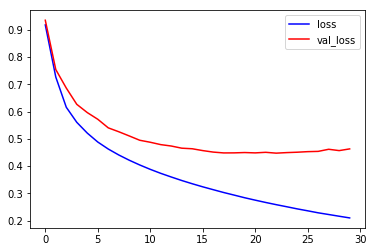

In [20]:
h = model.history.history
plt.plot(h['loss'], 'b-')
plt.plot(h['val_loss'], 'r-')
plt.legend(['loss','val_loss'])

### 번역 실행

In [22]:
enc_model = Model(enc_input, enc_states)

In [23]:
dec_input_h = Input(shape=(256,))
dec_input_c = Input(shape=(256,))
dec_states_input = [dec_input_h, dec_input_c]

In [24]:
dec_outputs, dec_h, dec_c = dec_lstm(dec_input, initial_state=dec_states_input)
dec_states = [dec_h, dec_c]

dec_outputs2 = dec_dense(dec_outputs)

dec_model = Model([dec_input] + dec_states_input, [dec_outputs2] + dec_states)

### 출력 테스트

In [25]:
def decode_sequence(seq):
    states_value = enc_model.predict(seq)
    
    output_seq = np.zeros([1,1,93]) # 93 은 불어사전 문자수
    output_seq[0,0,output_chars.index('\t')] = 1 # 첫번째 입력문자를 '\t' 로 설정
    
    stop = False
    result = ''
    
    while not stop:
        output_tokens, h, c = dec_model.predict([output_seq] + states_value)
        result += output_chars[np.argmax(output_tokens[0,-1,:])]
        
        if (result[-1]=='\n' or len(result)>=59): # 59는 불어 문장 최대 길이
            stop = True
            
        output_seq = np.zeros([1,1,93]) # 93 은 불어사전 문자수
        output_seq[0,0,np.argmax(output_tokens[0,-1])] = 1
        states_value = [h,c]
        
    return result

In [26]:
for i in range(2):
    seq = enc_in_data[5000+i:5000+i+1]
    result = decode_sequence(seq)
    
    print('################################')
    print(input_texts[5000+i])
    print('=>')
    print(result)

################################
He broke them.
=>
Il nous a laissés partir.

################################
He can't sing.
=>
Il ne sait pas nager.



In [29]:
start = 200
for i in range(2):
    seq = enc_in_data[start+i:start+i+1]
    result = decode_sequence(seq)
    
    print('################################')
    print(input_texts[start+i])
    print(output_texts[start+i][1:-1])
    print('=>')
    print('[%s]' % result.replace(' ','_'))

################################
Take it.
Prenez-le !
=>
[Prenez_les_miens.
]
################################
Tell me.
Dis-moi !
=>
[Dis-moi_!
]


### 새로운 문장으로 테스트

In [37]:
s1, s2 = lines[10010].strip().split('\t')
v = [input_chars.index(c) for c in s1]

a = np.zeros([1,16,70])
for i in range(len(v)):
    a[0,i,v[i]] = 1
    
r = decode_sequence(a)
display(s1, s2, r[:-1])

"Don't attack me."

"Ne m'attaque pas !"

'Ne me tuit pas !'